# Analyze the results of tree trimming



## Setup

In [246]:
import os 
import gc
import re
import csv
import glob
import math
import umap
import json
import itertools
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from scipy import stats
from collections import * 
from sklearn import cluster
from sklearn import decomposition
from ete4 import NCBITaxa, Tree
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


In [2]:
import sys
sys.path.append('../repo-armbrust-metat-search')

In [3]:
import functions.fn_metat_files as fnf

In [96]:
ncbi = NCBITaxa()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [6]:
workdir = '/scratch/bgrodner/iron_ko_contigs'
os.chdir(workdir)


In [7]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [8]:
os.listdir()

['config.yaml',
 'sc_run_snakemake.sh',
 'file_table.240210.kofam_filt.csv',
 '._.DS_Store',
 'file_table.240107.kofam_filt.csv',
 'apptainer_home',
 'file_table.240109.kofam_filt.csv',
 'file_table_new.csv',
 '._file_table.240109.kofam_filt.csv',
 'file_table.test.csv',
 'jupyter_home',
 '._file_table.240210.kofam_filt.csv',
 '._file_table.240107.kofam_filt.csv',
 'ko00001.json',
 '._file_table_new.csv',
 'file_table.240114.kofam_filt.csv',
 'metat_search_results',
 '._file_table.csv',
 'file_table.240113.kofam_filt.csv',
 'file_table.240107.kofam_unfilt.csv',
 'tidytest.csv',
 '._file_table.240108.kofam_filt.csv',
 'kofam_filenames.txt',
 '.etetoolkit',
 'iron_contigs.txt',
 '.DS_Store',
 'iron_KOs.txt',
 'file_table.240108.kofam_filt.csv',
 'file_table.csv',
 '._file_table.240107.kofam_unfilt.csv',
 '._plt_KO_contig_counts.png',
 '._file_table.test.csv',
 '._file_table.240113.kofam_filt.csv',
 '._file_table.240114.kofam_filt.csv',
 '.snakemake']

Plotting

In [9]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o',
    cmap_name='tab20',
    cl_lab=False
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle,
            cmap=cmap_name
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


#### Get KO dict

Get dataframe

In [91]:
ko_fn = "ko00001.json"
database = list()
for _, v in pd.read_json(ko_fn).iterrows():
    d = v["children"]
    cat_1 = d["name"]
    for child_1 in d["children"]:
        cat_2 = child_1["name"] # Module?
        for child_2 in child_1["children"]:
            cat_3 = child_2["name"]
            if "children" in child_2:
                for child_3 in child_2["children"]:
                    cat_4 = child_3["name"]
                    fields = [cat_1, cat_2, cat_3, cat_4]
                    database.append(fields)
df_kegg = pd.DataFrame(database, columns=["Level_A", "Level_B", "Level_C", "Level_D"])
df_kegg.shape


(61993, 4)

In [92]:
ld = df_kegg['Level_D'].values
ld[:5]

array(['K00844  HK; hexokinase [EC:2.7.1.1]',
       'K12407  GCK; glucokinase [EC:2.7.1.2]',
       'K00845  glk; glucokinase [EC:2.7.1.2]',
       'K25026  glk; glucokinase [EC:2.7.1.2]',
       'K01810  GPI, pgi; glucose-6-phosphate isomerase [EC:5.3.1.9]'],
      dtype=object)

In [93]:
dict_ko_name = {}
for name in ld:
    ko = re.search(r"^\w+",name)[0]
    dict_ko_name[ko] = name

## Load example data

G1PA filenames

In [131]:
dir_ko_dict = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig'
fn_dict_ko_contigs = f'{dir_ko_dict}/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-dict.json'

fn_dict_taxtrim_contigs = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-tidys/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-dict_taxtrim_contigs.json'

dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count'
glob_fn = f'{dir_counts}/*G1PA*.json'
fns = glob.glob(glob_fn)

fn_dict_contig_taxon = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_tax/NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz-iron_KOs.txt-dict_contig_taxid.json'

Load estcounts ordered by sample

In [ ]:
dict_contig_estcounts = defaultdict(list)
for fn in fns:
    # Load counts
    with open(fn, 'r') as f:
        dict_ctg_cnt = json.load(f)
    for ctg, cnt in dict_ctg_cnt.items():
        # map contig to counts
        dict_contig_estcounts[ctg].append(float(cnt[0]))

Load ko contigs and get inverted dict and rework contig from 6tr format

In [50]:
with open(fn_dict_ko_contigs, 'r') as f:
    dict_ko_contigs = json.load(f)

dict_contig_ko = {}
dict_ko_contigs_new = defaultdict(list)
for ko, contigs in dict_ko_contigs.items():
    for c in contigs:
        c_ = re.sub(r'_\d+$','',c)
        dict_ko_contigs_new[ko].append(c_)
        dict_contig_ko[c_] = ko
dict_ko_contigs = dict_ko_contigs_new

Load taxtrim contigs and undo 6tr and get inverted dict

In [53]:
with open(fn_dict_taxtrim_contigs, 'r') as f:
    dict_taxtrim_contigs = json.load(f)

dict_taxtrim_contigs_new = defaultdict(list)
dict_contig_taxtrim = {}
for tid, contigs in dict_taxtrim_contigs.items():
    for c in contigs:
        c_ = re.sub(r'_\d+$','',c)
        dict_taxtrim_contigs_new[tid].append(c_)
        dict_contig_taxtrim[c_] = tid

dict_taxtrim_contigs = dict_taxtrim_contigs_new

Load untrimmed taxa and undo 6tr

In [136]:
with open(fn_dict_contig_taxon, 'r') as f:
    dict_contig_taxon = json.load(f)

dict_contig_taxon_new= {}
for c, tid in dict_contig_taxon.items():
    c_ = re.sub(r'_\d+$','',c)
    dict_contig_taxon_new[c_] = tid

dict_contig_taxon = dict_contig_taxon_new

List of samples:

In [31]:
samples = []
for fn in fns:
    samples.append(re.search(r'(?<=\.tar\.gz\.).+(?=\.tsv-)', fn)[0])
samples[:3]

['G1PA.S12C1_0.2umB.abundance',
 'G1PA.S04C1_0.2umA.abundance',
 'G1PA.S13C1_0.2umA.abundance']

Get metadata for samples

In [30]:
meta_fn = '/scratch/bgrodner/repo-armbrust-metat/gradients1/g1_station_pa_metat/sample_metadata.csv'
meta = pd.read_csv(meta_fn)
df_meta = []
for s in samples:
    sid = re.search(r"(?<=G1PA\.).+(?=\.abundance)", s)[0]
    sid = re.sub('\.','_',sid)
    row = meta[meta['SampleID'] == sid].squeeze()
    df_meta.append(row)
df_meta = pd.DataFrame(df_meta, index=samples)
df_meta[:3]

,SampleID,Cruise,Station,Cast,Filter,Replicate,Depth,Datetime,Latitude,Longitude,SequencingID,Alias1,Alias2,Notes
G1PA.S12C1_0.2umB.abundance,S12C1_0_2umB,kok1606,12,1.0,0.2,B,15,4/30/16 15:01,33.091167,158.000833,175900.0,S12C1_0.2umB,S12C1_0.2umB,NaN
G1PA.S04C1_0.2umA.abundance,S04C1_0_2umA,kok1606,4,1.0,0.2,A,15,4/22/16 15:01,28.143167,158.000667,175910.0,S4C1_0.2umA,S04C1_0.2umA,NaN
G1PA.S13C1_0.2umA.abundance,S13C1_0_2umA,kok1606,13,1.0,0.2,A,15,5/1/16 14:58,29.699833,157.999333,175904.0,S13C1_0.2umA,S13C1_0.2umA,NaN


## Raw numbers

How many KOs, contigs, taxa, samples are there?

In [68]:
print(f"""
There are 
    {len(dict_ko_contigs)} KOs 
    {len(dict_taxtrim_contigs)} taxa
    {len(dict_contig_estcounts):,} contigs
    {len(next(iter(dict_contig_estcounts.values())))} samples
      """)


There are 
    257 KOs 
    92 taxa
    213,789 contigs
    47 samples
      


How many taxon-ko pairs are there?

In [101]:
ko_taxon_pairs = set()
for ko, contigs in dict_ko_contigs.items():
    for c in contigs:
        tax = dict_contig_taxtrim.get(c)
        if tax:
            ko_taxon_pairs.add(f'{ko}-{tax}')
print(f"""
There are 
    {len(ko_taxon_pairs)} KO-taxon pairs 
      """)


There are 
    5330 KO-taxon pairs 
      


Metadata info

In [43]:
print(f"""
There are
    Depths:\t{df_meta['Depth'].unique()}
    Filter:\t{df_meta['Filter'].unique()}
    Latitude:\t{[float(round(l,2)) for l in df_meta['Latitude'].sort_values().unique()]}
    Longitude:\t{[float(round(l,2)) for l in df_meta['Longitude'].sort_values().unique()]}
""")


There are
    Depths:	[15]
    Filter:	[0.2 3. ]
    Latitude:	[23.5, 26.28, 28.14, 29.7, 32.58, 33.09, 35.46, 36.57, 36.57, 37.3]
    Longitude:	[157.99, 158.0, 158.0, 158.0, 158.0, 158.0, 158.0, 158.0]



## Distributions

How many samples is each KO in?

In [56]:
dict_ko_nsams = {}
for ko, contigs in dict_ko_contigs.items():
    sams = np.zeros(len(samples))
    for c in contigs:
        sams += dict_contig_estcounts[c]
    dict_ko_nsams[ko] = sams.astype(bool).sum()



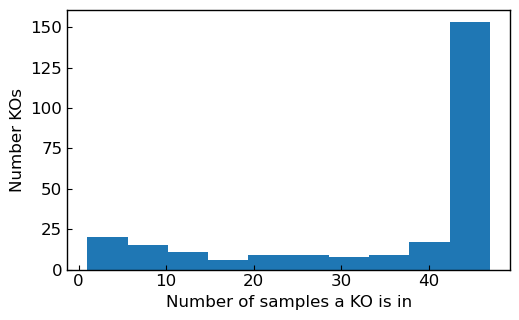

In [57]:
fig, ax = general_plot()
_ = ax.hist(list(dict_ko_nsams.values()))
_ = ax.set_xlabel('Number of samples a KO is in')
_ = ax.set_ylabel('Number KOs')

How many taxa is each KO in?

In [61]:
dict_ko_ntax = {}
for ko, contigs in dict_ko_contigs.items():
    taxa = set()
    for c in contigs:
        tid = dict_contig_taxtrim.get(c)
        if tid:
            taxa.add(tid)
    dict_ko_ntax[ko] = len(taxa)

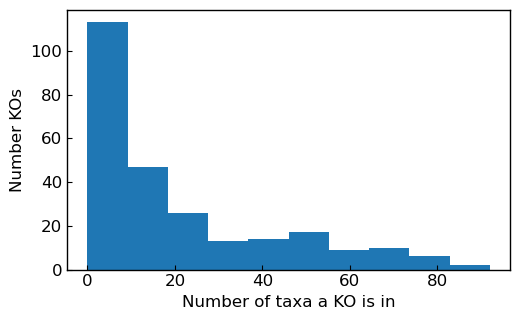

In [62]:
fig, ax = general_plot()
_ = ax.hist(list(dict_ko_ntax.values()))
_ = ax.set_xlabel('Number of taxa a KO is in')
_ = ax.set_ylabel('Number KOs')

How many samples is each taxon in?

In [74]:
dict_tax_nsams = {}
for tax, contigs in dict_taxtrim_contigs.items():
    sams = np.zeros(len(samples))
    for c in contigs:
        sams += dict_contig_estcounts[c]
    dict_tax_nsams[tax] = sams.astype(bool).sum()



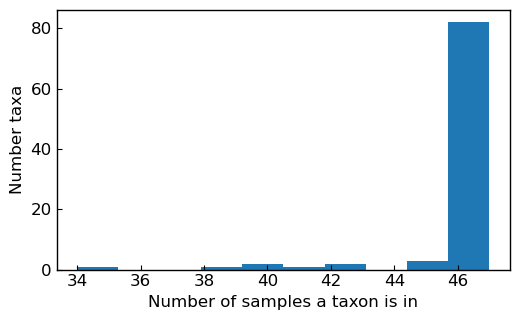

In [75]:
fig, ax = general_plot()
_ = ax.hist(list(dict_tax_nsams.values()))
_ = ax.set_xlabel('Number of samples a taxon is in')
_ = ax.set_ylabel('Number taxa')

How many KOs does each taxon have?

In [69]:
dict_tax_nkos = {}
for tax, contigs in dict_taxtrim_contigs.items():
    kos = set()
    for c in contigs:
        ko = dict_contig_ko.get(c)
        if ko:
            kos.add(ko)
    dict_tax_nkos[tax] = len(kos)

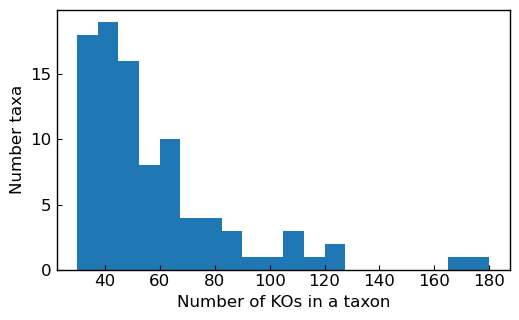

In [71]:
fig, ax = general_plot()
_ = ax.hist(list(dict_tax_nkos.values()), bins=20)
_ = ax.set_xlabel('Number of KOs in a taxon')
_ = ax.set_ylabel('Number taxa')

How many samples is each KO in each taxon in?

In [84]:
dict_ko_tax_estcounts = defaultdict(lambda: defaultdict(lambda: np.zeros(len(samples))))
for ko, contigs in dict_ko_contigs.items():
    for c in contigs:
        tax = dict_contig_taxtrim.get(c)
        if tax:
            dict_ko_tax_estcounts[ko][tax] += dict_contig_estcounts[c]
kotax_nsams = []
for ko, d in dict_ko_tax_estcounts.items():
    for tax, ec in d.items():
        kotax_nsams.append(ec.astype(bool).sum())



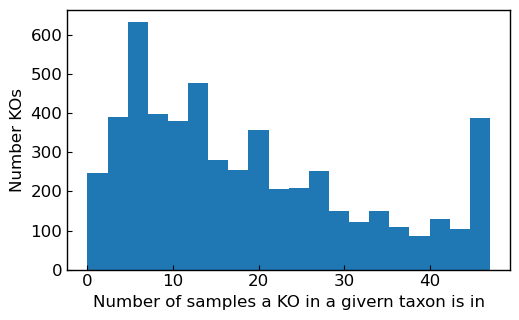

In [88]:
fig, ax = general_plot()
_ = ax.hist(kotax_nsams, bins=20)
_ = ax.set_xlabel('Number of samples a KO in a givern taxon is in')
_ = ax.set_ylabel('Number KOs')

### Inspect interesting subsets

Which KOs are not in all the samples?

In [94]:
for ko, nsams in dict_ko_nsams.items():
    if nsams < 20:
        print(dict_ko_name[ko])

K00174  korA, oorA, oforA; 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit alpha [EC:1.2.7.3 1.2.7.11]
K00176  korD, oorD; 2-oxoglutarate ferredoxin oxidoreductase subunit delta [EC:1.2.7.3]
K00205  fwdF, fmdF; 4Fe-4S ferredoxin
K00216  entA; 2,3-dihydro-2,3-dihydroxybenzoate dehydrogenase [EC:1.3.1.28]
K00367  narB; ferredoxin-nitrate reductase [EC:1.7.7.2]
K00370  narG, narZ, nxrA; nitrate reductase / nitrite oxidoreductase, alpha subunit [EC:1.7.5.1 1.7.99.-]
K00371  narH, narY, nxrB; nitrate reductase / nitrite oxidoreductase, beta subunit [EC:1.7.5.1 1.7.99.-]
K00372  nasC,  nasA; assimilatory nitrate reductase catalytic subunit [EC:1.7.99.-]
K00532  E1.12.7.2; ferredoxin hydrogenase [EC:1.12.7.2]
K01743  E4.2.1.1; carbonic anhydrase [EC:4.2.1.1]
K02015  ABC.FEV.P; iron complex transport system permease protein
K02446  glpX; fructose-1,6-bisphosphatase II [EC:3.1.3.11]
K02598  nirC; nitrite transporter
K02700  psaM; photosystem I subunit XII
K02707  psbE; photosystem II

Which KOs are in many taxa?

In [95]:
for ko, ntax in dict_ko_ntax.items():
    if ntax > 60:
        print(dict_ko_name[ko])

K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
K00264  GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
K00284  GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
K00592  RBCMT; [ribulose-bisphosphate carboxylase]/[fructose-bisphosphate aldolase]-lysine N-methyltransferase [EC:2.1.1.127 2.1.1.259]
K00615  E2.2.1.1, tktA, tktB; transketolase [EC:2.2.1.1]
K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]
K00927  PGK, pgk; phosphoglycerate kinase [EC:2.7.2.3]
K01674  cah; carbonic anhydrase [EC:4.2.1.1]
K01726  GAMMACA; gamma-carbonic anhydrase [EC:4.2.1.-]
K01783  rpe, RPE; ribulose-phosphate 3-epimerase [EC:5.1.3.1]
K02364  entF; L-serine---[L-seryl-carrier protein] ligase [EC:6.3.2.14 6.2.1.72]
K02575  NRT2, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter
K02641  petH; ferredoxin--NADP+ reductase [EC:1.18.1.2]
K03320  amt, AMT, MEP; ammonium transporter, Amt family
K03699  tlyC; magnesium and cobalt exporter

Which taxa are not in all the samples?

In [98]:
for tax, nsams in dict_tax_nsams.items():
    if nsams < 47:
        print(ncbi.get_taxid_translator([tax]))

{1203019: 'Gymnodinium catenatum GC744'}
{1333877: 'Zooxanthella nutricula'}
{1411661: 'Bolidomonas sp. 1657'}
{156132: 'Prasinoderma'}
{216776: 'Proboscia'}
{242159: "Ostreococcus sp. 'lucimarinus'"}
{2509521: 'unclassified Micromonas'}
{33317: 'Protostomia'}
{33836: 'Coscinodiscophyceae'}
{33852: 'Bacillariaceae'}
{38832: 'Micromonas'}
{41874: 'Bathycoccus'}
{41875: 'Bathycoccus prasinos'}
{44056: 'Aureococcus anophagefferens'}
{565004: 'Paracyclopina nana'}
{6073: 'Cnidaria'}
{6833: 'Calanoida'}


Which taxa have lots of KOs?

In [102]:
for tax, nkos in dict_tax_nkos.items():
    if nkos > 90:
        print(ncbi.get_taxid_translator([tax]))

{131567: 'cellular organisms'}
{2608131: 'Prymnesiophyceae'}
{2696291: 'Ochrophyta'}
{2698737: 'Sar'}
{2759: 'Eukaryota'}
{2864: 'Dinophyceae'}
{35677: 'Pelagomonas calceolata'}
{407301: 'Karlodinium veneficum'}
{40984: 'Gonyaulacales'}
{43686: 'Pelagodinium beii'}


## Compare bacteria and eukaryotes

Get dict defining each taxon as bacteria or eukaryote

In [110]:
lineage

[1, 131567, 2759, 2698737, 33634, 2696291, 2825, 96792]

In [111]:
dict_taxtrim_bacteuk = {}
for tax, _ in dict_taxtrim_contigs.items():
    lineage = ncbi.get_lineage(tax)
    if 2759 in lineage:
        dict_taxtrim_bacteuk[tax] = 'Eukaryota'
    elif 2 in lineage:
        dict_taxtrim_bacteuk[tax] = 'Bacteria'
    else:
        dict_taxtrim_bacteuk[tax] = 'other'

How many bacterial vs eukaryota KOs?

In [123]:
dict_ko_ebs = {}
for ko, contigs in dict_ko_contigs.items():
    ebs = set()
    for c in contigs:
        tax = dict_contig_taxtrim.get(c)
        if tax:
            eb = dict_taxtrim_bacteuk[tax]
            ebs.add(eb)
    if ebs:
        dict_ko_ebs[ko] = ', '.join(str(x) for x in ebs)
    else:
        dict_ko_ebs[ko] = 'none'
    

/tmp/ipykernel_1947816/2977368977.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(names,rotation=45, ha='right')


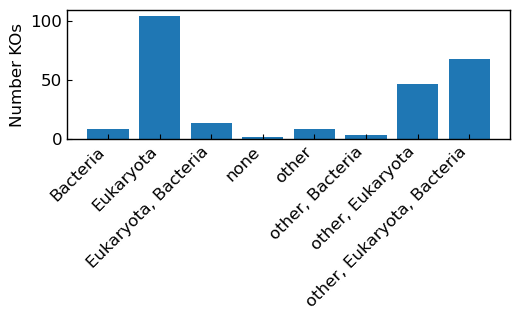

In [124]:
names, counts = np.unique(list(dict_ko_ebs.values()), return_counts=True)

fig, ax = general_plot()
_ = ax.bar(names, counts)
_ = ax.set_ylabel('Number KOs')
_ = ax.set_xticklabels(names,rotation=45, ha='right')

Which KOs are only in bacteria?

In [126]:
for ko, ebs, in dict_ko_ebs.items():
    if (ebs == 'Bacteria') | (ebs == 'other, Bacteria'):
        print(dict_ko_name[ko])

K00179  iorA; indolepyruvate ferredoxin oxidoreductase, alpha subunit [EC:1.2.7.8]
K00371  narH, narY, nxrB; nitrate reductase / nitrite oxidoreductase, beta subunit [EC:1.7.5.1 1.7.99.-]
K00372  nasC,  nasA; assimilatory nitrate reductase catalytic subunit [EC:1.7.99.-]
K03594  bfr; bacterioferritin [EC:1.16.3.1]
K03832  tonB; periplasmic protein TonB
K08942  pscC; photosystem P840 reaction center cytochrome c551
K11604  sitA; manganese/iron transport system substrate-binding protein
K11605  sitC; manganese/iron transport system permease protein
K11645  fbaB; fructose-bisphosphate aldolase, class I [EC:4.1.2.13]
K16087  TC.FEV.OM3, tbpA, hemR, lbpA, hpuB, bhuR, hugA, hmbR; hemoglobin/transferrin/lactoferrin receptor protein
K16088  TC.FEV.OM1, fhuE, fpvA, fptA; outer-membrane receptor for ferric coprogen and ferric-rhodotorulic acid
K16090  fiu; catecholate siderophore receptor
K24147  entH; proofreading thioesterase EntH


Which KOs are Eukariota and bacteria?

In [127]:
for ko, ebs, in dict_ko_ebs.items():
    if (ebs == 'Eukaryota, Bacteria'):
        print(dict_ko_name[ko])

K00360  nasB; assimilatory nitrate reductase electron transfer subunit [EC:1.7.99.-]
K00361  nasB; nitrite reductase [NAD(P)H] [EC:1.7.1.4]
K00370  narG, narZ, nxrA; nitrate reductase / nitrite oxidoreductase, alpha subunit [EC:1.7.5.1 1.7.99.-]
K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]
K02719  psbU; photosystem II PsbU protein
K04792  mbtF; mycobactin peptide synthetase MbtF
K05710  hcaC; 3-phenylpropionate/trans-cinnamate dioxygenase ferredoxin component
K07685  narP; two-component system, NarL family, nitrate/nitrite response regulator NarP
K09681  gltC; LysR family transcriptional regulator, transcription activator of glutamate synthase operon
K12239  pchE; L-cysteine---[L-cysteinyl-carrier protein] ligase PchE [EC:6.2.1.69]
K15721  fyuA; pesticin/yersiniabactin receptor
K15762  tmoC, tbuB, touC; toluene monooxygenase system ferredoxin subunit
K16074  zntB; zinc transporter
K22736  VIT; vacuolar iron transporter family protein


Which taxa are the siderophore KOs in?

In [130]:
kos = ['K04792','K15721','K22736']
dict_kotarget_taxa = defaultdict(set)
for ko in kos:
    contigs = dict_ko_contigs[ko]
    for c in contigs:
        tax = dict_contig_taxtrim.get(c)
        if tax:
            dict_kotarget_taxa[ko].add(tax)

for ko, taxa in dict_kotarget_taxa.items():
    print(dict_ko_name[ko])
    for tid in taxa:
        print(f'\t{ncbi.get_taxid_translator([tid])}')

K04792  mbtF; mycobactin peptide synthetase MbtF
	{43686: 'Pelagodinium beii'}
	{35677: 'Pelagomonas calceolata'}
	{156230: 'Karenia brevis'}
	{2916: 'Tripos fusus'}
	{2608131: 'Prymnesiophyceae'}
	{2864: 'Dinophyceae'}
	{35143: 'Prymnesium'}
	{418966: 'Noelaerhabdaceae'}
	{2: 'Bacteria'}
	{40984: 'Gonyaulacales'}
	{1573500: 'Pyrocystaceae'}
K15721  fyuA; pesticin/yersiniabactin receptor
	{1224: 'Pseudomonadota'}
	{2759: 'Eukaryota'}
K22736  VIT; vacuolar iron transporter family protein
	{2698737: 'Sar'}
	{35677: 'Pelagomonas calceolata'}
	{2759: 'Eukaryota'}
	{33656: 'Phaeocystis'}
	{2608131: 'Prymnesiophyceae'}
	{2864: 'Dinophyceae'}
	{1003176: 'Kareniaceae'}
	{2: 'Bacteria'}
	{33657: 'Phaeocystis antarctica'}
	{35140: 'Chrysochromulina'}
	{407301: 'Karlodinium veneficum'}


Which taxa (untrimmed?) are the siderophore KOs in?

In [138]:
kos = ['K04792','K15721','K22736']
dict_kotarget_taxa = defaultdict(set)
for ko in kos:
    contigs = dict_ko_contigs[ko]
    for c in contigs:
        tax = dict_contig_taxon.get(c)[0]
        if tax:
            dict_kotarget_taxa[ko].add(tax)

for ko, taxa in dict_kotarget_taxa.items():
    print(dict_ko_name[ko])
    for tid in taxa:
        print(f'\t{ncbi.get_taxid_translator([tid])}')

K04792  mbtF; mycobactin peptide synthetase MbtF
	{43686: 'Pelagodinium beii'}
	{35677: 'Pelagomonas calceolata'}
	{156230: 'Karenia brevis'}
	{2916: 'Tripos fusus'}
	{203124: 'Trichodesmium erythraeum IMS101'}
	{97485: 'Prymnesium parvum'}
	{2864: 'Dinophyceae'}
	{418966: 'Noelaerhabdaceae'}
	{418940: 'Scyphosphaera apsteinii'}
	{2: 'Bacteria'}
	{40984: 'Gonyaulacales'}
	{}
	{1573500: 'Pyrocystaceae'}
K15721  fyuA; pesticin/yersiniabactin receptor
	{53246: 'Pseudoalteromonas'}
	{2759: 'Eukaryota'}
K22736  VIT; vacuolar iron transporter family protein
	{2698737: 'Sar'}
	{35677: 'Pelagomonas calceolata'}
	{2759: 'Eukaryota'}
	{33656: 'Phaeocystis'}
	{2608131: 'Prymnesiophyceae'}
	{2864: 'Dinophyceae'}
	{1003176: 'Kareniaceae'}
	{418940: 'Scyphosphaera apsteinii'}
	{2713251: 'Abedinium folium'}
	{33657: 'Phaeocystis antarctica'}
	{1321778: 'Clostridiales bacterium oral taxon 876 str. F0540'}
	{35140: 'Chrysochromulina'}
	{407301: 'Karlodinium veneficum'}


## Hamming distances between ko-taxon pairs

Get boolean array

In [141]:
arr_kotax = []
index_kotax = []
for ko, d in dict_ko_tax_estcounts.items():
    for tax, ec in d.items():
        index_kotax.append(f"{ko}-{tax}")
        arr_kotax.append(ec.astype(bool))
arr_kotax = np.array(arr_kotax)
arr_kotax.shape

(5330, 47)

UMAP on array

In [149]:
nn = 7
reducer = umap.UMAP(metric='hamming', n_neighbors=nn)
embedding = reducer.fit_transform(arr_kotax)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


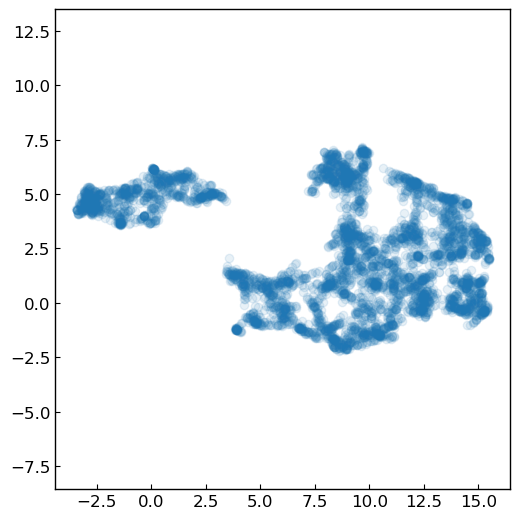

In [150]:
dims = (5,5)
alpha = 0.1
fig, ax = general_plot(dims=dims)
_ = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=alpha
)
_ = ax.set_aspect('equal','datalim')

Cluster ko-taxon pairs

In [ ]:
dists = distance.pdist(arr_kotax, metric='hamming')

In [188]:
link = hierarchy.linkage(dists, method='centroid')

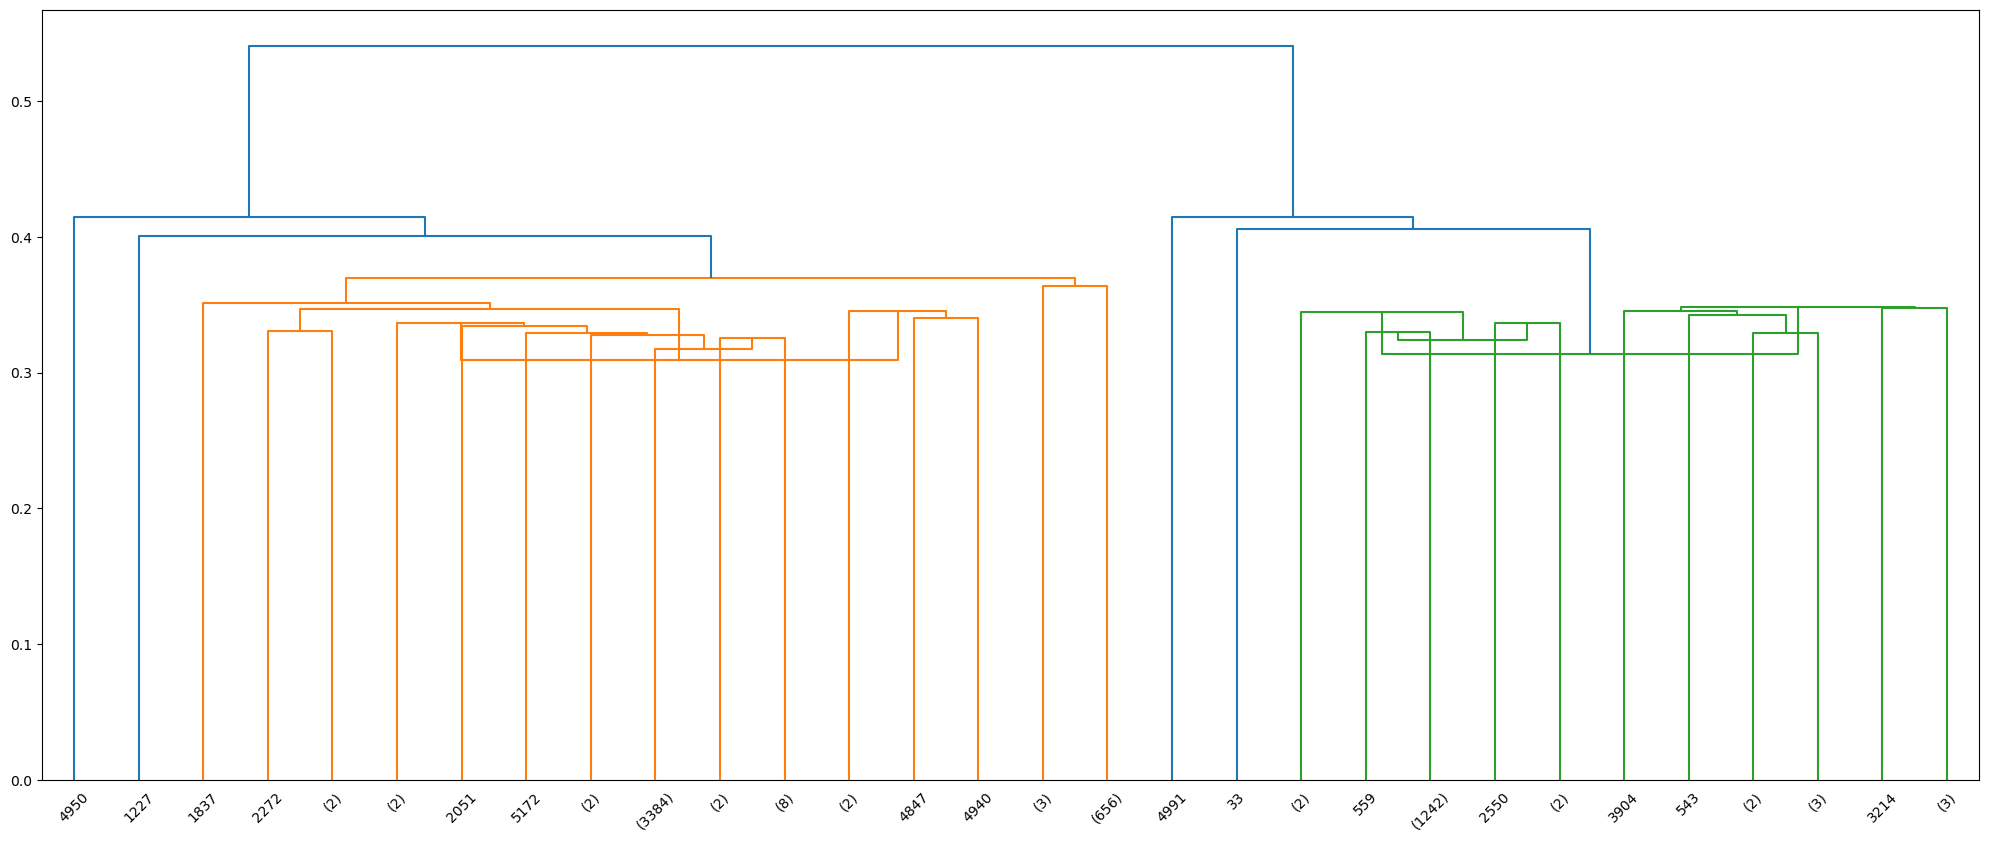

In [189]:
fig = plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(link, truncate_mode='lastp')

In [200]:
t = 0.2
clust_hier = hierarchy.fcluster(link, t=t, criterion='distance')
# nclust = 6
# clust_hier = hierarchy.fcluster(link, t=nclust, criterion='maxclust')


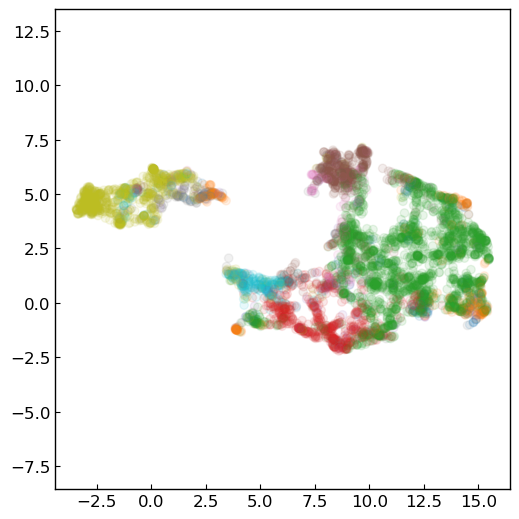

In [201]:
dims = (5,5)
alpha = 0.1
fig, ax = general_plot(dims=dims)
_ = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=alpha,
    c=clust_hier,
    cmap='tab10'
)
_ = ax.set_aspect('equal','datalim')

In [202]:
np.unique(clust_hier, return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

Try with agglomerative clustering

In [175]:
dists_square = distance.squareform(dists)

In [183]:
clust_agg_fit = cluster.AgglomerativeClustering(metric='precomputed', linkage='complete').fit(dists_square)
clust_agg = clust_agg_fit.labels_

In [184]:
np.unique(clust_agg, return_counts=True)

(array([0, 1]), array([1989, 3341]))

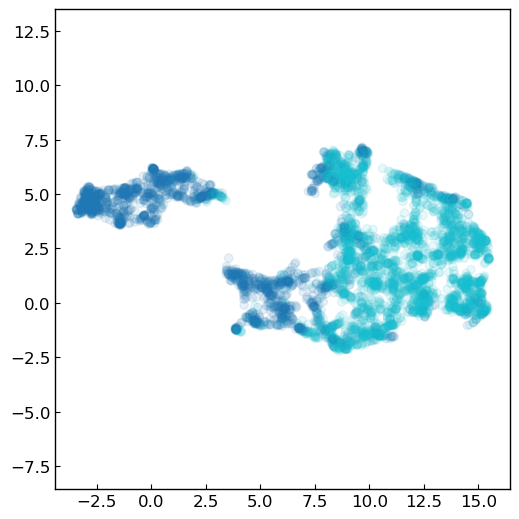

In [185]:
dims = (5,5)
alpha = 0.1
fig, ax = general_plot(dims=dims)
_ = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=alpha,
    c=clust_agg,
    cmap='tab10'
)
_ = ax.set_aspect('equal','datalim')

What is the distribution across samples for each cluster?

In [199]:
cl_df = []
clusts = np.unique(clust_agg)
for cl in clusts:
    col = arr_kotax[clust_agg == cl].mean(axis=0).squeeze()
    cl_df.append(col)

pd.DataFrame(np.array(cl_df).T, columns=clusts, index=samples).sort_index()

,0,1
G1PA.S02C1_0.2umA.abundance,0.598793,0.121221
G1PA.S02C1_0.2umB.abundance,0.529915,0.083508
G1PA.S02C1_0.2umC.abundance,0.641026,0.150254
G1PA.S02C1_3umA.abundance,0.619910,0.299012
G1PA.S02C1_3umB.abundance,0.646556,0.310087
G1PA.S02C1_3umC.abundance,0.613876,0.288237
G1PA.S04C1_0.2umA.abundance,0.662645,0.121820
G1PA.S04C1_0.2umB.abundance,0.724485,0.161329
G1PA.S04C1_0.2umC.abundance,0.690799,0.146363
G1PA.S04C1_3umA.abundance,0.548517,0.250823


So seemingly ^ cluster 1 is just ko-taxon pairs with fewer samples and cluster 0 is those with all or almost all the samples

### Find groups of taxon-ko pairs with very small hamming distance

What is the metric for 1, 2, 3 disagreements?

In [205]:
for i in range(10):
    print(i, i / len(samples))

0 0.0
1 0.02127659574468085
2 0.0425531914893617
3 0.06382978723404255
4 0.0851063829787234
5 0.10638297872340426
6 0.1276595744680851
7 0.14893617021276595
8 0.1702127659574468
9 0.19148936170212766


Get 1 disagreement

In [208]:
t = 0.03
clust_hier = hierarchy.fcluster(link, t=t, criterion='distance')
clusts, counts = np.unique(clust_hier, return_counts=True)
print(counts[counts > 1])


[  2   2   2   2   2   2   3   2   2   2   2   2   4   2   4   2   2   2
   3   2   2   5   2   3   2   2   2   2   2   2   8   3   4   2   2   2
   3   2   2   4   2   2   2   2   3   3   2   2   2   3   2   2   2   2
   2   2   4   2   2   2   2   2   2  11   6   2   2   2   2   2   4   3
   2   5   2   2   2   2   2   2   2   2   2   9   4   3   2  10   5   7
   6   2   4   2   3   5   5   4  10   2   7   2   6   4   5   3   3   3
   8   5  31   2   6   5   5   2   2   7   7   2   2   4   3   2   3   3
   2   2   8   2   2   2   2   3   2   2   2   2   5   4   2   2   3   2
   2   3   2   4   2   2   2   2   2   2   4   2   3   2   2   2   2   3
   2   4   2   2   2   2   2   2   2   2   2  15  14   2   2   2   2   3
   2   2   2   3   2   2   2   2   3  10   2   3   2   2   2   2   4   2
   2   3   3   2   2   2   2   3   2   2   2   2   2   2   2   2   2   2
   2   4   4   2   2   2   2   2   2   2   2   2   2   2   4   6   2   2
   2   2   4   2   2   2   4   4   2   2   7   2   

#### Look at the big cluster

In [215]:
clids = clusts[counts >= 310]
clids

array([3958], dtype=int32)

In [228]:
for clid in clids:
    bool_ind = (clust_hier == clid)
    inds = np.array(index_kotax)[bool_ind]
    arr_sub = arr_kotax[bool_ind]
    print(arr_sub.mean(axis=0))

[0.         0.09677419 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.06451613 0.         0.
 0.03225806 0.03225806 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.06451613 0.         0.         0.         0.        ]


^ This is the ko-taxa that are present across almost all samples

#### Look at the next biggest cluster

In [225]:
clids = clusts[counts == 31]
clids

array([1255], dtype=int32)

In [227]:
for clid in clids:
    bool_ind = (clust_hier == clid)
    inds = np.array(index_kotax)[bool_ind]
    arr_sub = arr_kotax[bool_ind]
    print(arr_sub.mean(axis=0))

[0.         0.09677419 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.06451613 0.         0.
 0.03225806 0.03225806 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.06451613 0.         0.         0.         0.        ]


^ this is the almost empty pairs

#### Look at some other clusters

In [229]:
clids = clusts[(counts > 10) & (counts < 30)]
clids

array([1148, 1463, 1464, 3954], dtype=int32)

In [231]:
for clid in clids:
    bool_ind = (clust_hier == clid)
    inds = np.array(index_kotax)[bool_ind]
    arr_sub = arr_kotax[bool_ind]
    print(clid)
    print(arr_sub.mean(axis=0))

1148
[0.         0.         0.         0.         0.         0.18181818
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.18181818 0.         0.09090909 0.         0.
 0.         0.         0.90909091 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         1.
 0.         0.         0.         0.         0.        ]
1463
[0.         0.06666667 0.         0.         0.         0.06666667
 0.         0.         0.         0.         0.         0.06666667
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.06666667 0.         0.         0.         0.
 0.06666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
1464
[0.         0.       

^ this is mixed some are interesting

### Get 2 disagreements

In [232]:
t = 0.05
clust_hier = hierarchy.fcluster(link, t=t, criterion='distance')
clusts, counts = np.unique(clust_hier, return_counts=True)
print(counts[counts > 1])


[  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   3   5
   2  10   2   2   2   2   2   4   7   2   2   2   5   5   3   2   9   3
   3   4   4   2  20   3   2   2   2   3   2   4   2   2   9   3   2   2
   3   3   2   4   2   5   2   2   2   2   2   3   2   2   2   2   2   2
   4   2   3   2   3   3   2   5   6   2   5  26   2   2   2   2   3   3
   2   3   2   5  16   2   2   2   2   2   6   2   4  15   3   2  32   2
   8 106  20  18   4   5   4   8   4   9   4   8   5   4   2   2   2   2
   9   4   3   6   2   5   5   3   2   2   2   3   4   2   2   3   2   4
   2   5   2   4   4   2   2   4   2   2   3   2  13   2   2   2   4   2
   7   5   3  32   2   2   5   2   9   7   6   4  17   3   2   2   2   3
   4   3   2   2   2   2   2   2   2   2  15   4   2   2   2   4   2   2
   2   4   3   4   2   2   2   3   2   2   4   6   3   2   2   2   2   2
   2   3   2   2   4   2   2   4   4   2   9   2   2   3   6   3   3   2
   2   2   2   2   2   2   2   2   2   4   2   4   

Get those with count greater than three and present in a moderate number of samples

In [244]:
for cl, cnt in zip(clusts, counts):
    if cnt > 3:
        bool_ind = (clust_hier == cl)
        arr_sub = arr_kotax[bool_ind]
        mn = arr_sub.mean(axis=0)
        npos = sum(mn > 0.5)
        if (npos > 3) & (npos < 10):
            print('\n\n',cl, '\n', mn)

            inds = np.array(index_kotax)[bool_ind]
            dict_tk = defaultdict(list)
            for kotax in inds:
                ko, tax = kotax.split('-')
                t = list(ncbi.get_taxid_translator([tax]).values())[0]
                k = dict_ko_name[ko]
                dict_tk[t].append(k)
            for t, ks in dict_tk.items():
                print('\t', t)
                for k in ks:
                    print('\t\t',k)




 573 
 [0.  0.  0.  0.4 0.  1.  0.  0.  0.2 1.  0.  0.  0.  0.  0.  0.4 0.  0.
 0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.
 0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0. ]
	 Gymnodinium catenatum GC744
		 K04780  dhbF; glyine---[glycyl-carrier protein] ligase [EC:6.2.1.66]
	 Paracyclopina nana
		 K13859  SLC4A8; solute carrier family 4 (sodium bicarbonate cotransporter), member 8
	 Thalassiosirophycidae
		 K14581  nahAa, nagAa, ndoR, nbzAa, dntAa; naphthalene 1,2-dioxygenase ferredoxin reductase component [EC:1.18.1.7]
		 K22071  FDX2; ferredoxin-2, mitochondrial
	 Emiliania huxleyi
		 K18245  CA2; carbonic anhydrase 2 [EC:4.2.1.1]


 610 
 [0.   0.   0.   1.   0.   0.25 0.   0.   1.   0.   0.   0.   0.   0.
 0.   1.   0.   0.   0.   0.   0.   0.   0.25 1.   0.   0.   1.   0.
 0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.
 0.   0.   0.   0.   0.  ]
	 Kareniaceae
		 K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]
	 Haptophyta
	

# Merged samples tree

Get tensor filename

In [245]:
fn_tensor = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-barnacle_tensor_tidy.csv'
os.path.exists(fn_tensor)

True

Get header

In [260]:
with open(fn_tensor, 'r') as f:
    print(next(f))
    print(next(f))


assm_sample,KO,taxon_trim,estcounts,rep

G1NS-S13C1-nan-nan-nan-3um,K15577,69277,0.0,A



Which csv reader is fastest?

In [261]:
with open(fn_tensor, 'r') as f:
    t0 = time()
    for i in range(10000):
        row = next(f)
        row = row.split(',')
        sample = row[0]
    t1 = time()
print(f"{(t1-t0) // 60} min {(t1-t0) % 60} sec")

0.0 min 0.0055844783782958984 sec


In [263]:
with open(fn_tensor, 'r') as f:
    reader = csv.reader(f)
    t0 = time()
    for i in range(10000):
        row = next(reader)
        sample = row[0]
    t1 = time()
print(f"{(t1-t0) // 60} min {(t1-t0) % 60} sec")

0.0 min 0.008070707321166992 sec


In [264]:
with open(fn_tensor, 'r') as f:
    reader = csv.DictReader(f)
    t0 = time()
    for i in range(10000):
        row = next(reader)
        sample = row['assm_sample']
    t1 = time()
print(f"{(t1-t0) // 60} min {(t1-t0) % 60} sec")

0.0 min 0.01964569091796875 sec


Read in dict

In [304]:
dict_taxtrim_ko_sample_estcounts = defaultdict(
    lambda: defaultdict(dict)
)
i = 0
with open(fn_tensor, 'r') as f:
    _ = next(f)
    for row in f:
        i += 1
        sample, ko, tax, estcounts, rep = row.split(',')
        sam = f"{sample}-{rep}"
        dict_taxtrim_ko_sample_estcounts[tax][ko][sam] = float(estcounts)
i

6112579

## Raw numbers

How many KOs, contigs, taxa, samples are there?

In [281]:
taxa_all = set()
kos_all = set()
samples_all = set()
taxko_all = set()
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
  taxa_all.add(tax)
  for ko, dse in dkse.items():
    taxko_all.add(f"{tax}-{ko}")
    kos_all.add(ko)
    for sam, ec in dse.items():
      samples_all.add(sam)

In [282]:
print(f"""
There are 
    {len(kos_all)} KOs 
    {len(taxa_all)} taxa
    {len(samples_all)} samples
    {len(taxko_all)} taxon-kos
      """)


There are 
    378 KOs 
    499 taxa
    531 samples
    44138 taxon-kos
      


## Tree

Build tree

In [299]:
tree = ncbi.get_topology(taxa_all)
for n in tree.traverse():
    if str(n.name) in taxa_all:
        kos = list(dict_taxtrim_ko_sample_estcounts[n.name].keys())
        nkos = len(kos)
    else:
        nkos = 'NA'
    n.add_props(
        nkos=nkos
    )


Plot tree

In [300]:
print(tree.to_str(props=['sci_name','name','nkos'], compact=True))

                                                                                                                                                                                                                                                                           ╭╴Alteromonas australica,589873,90
                                                                                                                                                                              ╭╴Alteromonadaceae,72275,87╶╌╴Alteromonas/Salinimonas group,2903219,56╶╌╴Alteromonas,226,189╶┼╴Alteromonas mediterranea,314275,47
                                                                                                                                                                              │                                                                                            ╰╴Alteromonas macleodii,28108,91
                                                                                              

## Distributions

How many samples is each KO in?

In [309]:
dict_ko_sam_ec = defaultdict(lambda: defaultdict(float))
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
    for ko, dse in dkse.items():
        for sam, ec in dse.items():
            dict_ko_sam_ec[ko][sam] += ec
dict_ko_nsams = {}
for ko, dse in dict_ko_sam_ec.items():
    nsam = 0
    for sam, ec in dse.items():
        if ec:
            nsam += 1
    dict_ko_nsams[ko] = nsam

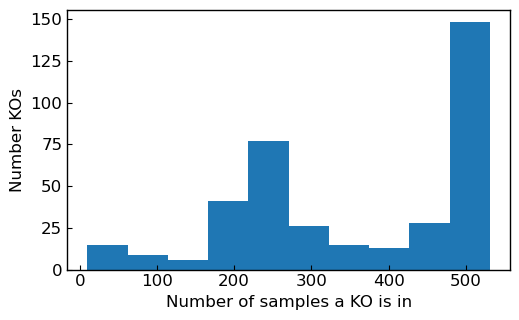

In [306]:
fig, ax = general_plot()
_ = ax.hist(list(dict_ko_nsams.values()))
_ = ax.set_xlabel('Number of samples a KO is in')
_ = ax.set_ylabel('Number KOs')

How many taxa is each KO in?

In [310]:
dict_ko_taxa = defaultdict(list)
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
    for ko, dse in dkse.items():
        dict_ko_taxa[ko].append(tax)

dict_ko_ntax = {}
for ko, taxa in dict_ko_taxa.items():
    dict_ko_ntax[ko] = len(taxa)

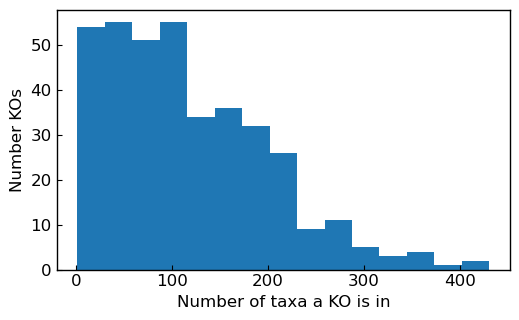

In [314]:
fig, ax = general_plot()
_ = ax.hist(list(dict_ko_ntax.values()), bins=15)
_ = ax.set_xlabel('Number of taxa a KO is in')
_ = ax.set_ylabel('Number KOs')

How many samples is each taxon in?

In [317]:
dict_tax_sam_ec = defaultdict(lambda: defaultdict(float))
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
    for ko, dse in dkse.items():
        for sam, ec in dse.items():
            dict_tax_sam_ec[tax][sam] += ec
dict_tax_nsams = {}
for tax, dse in dict_tax_sam_ec.items():
    nsam = 0
    for sam, ec in dse.items():
        if ec:
            nsam += 1
    dict_tax_nsams[tax] = nsam



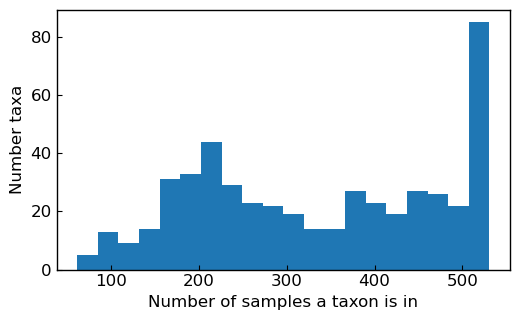

In [330]:
fig, ax = general_plot()
_ = ax.hist(list(dict_tax_nsams.values()), bins=20)
_ = ax.set_xlabel('Number of samples a taxon is in')
_ = ax.set_ylabel('Number taxa')

How many KOs does each taxon have?

In [319]:
dict_tax_nkos = {}
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
    dict_tax_nkos[tax] = len(dkse)

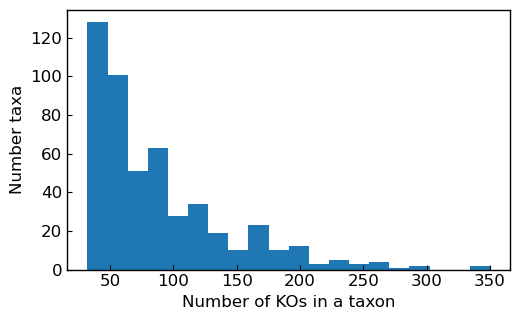

In [320]:
fig, ax = general_plot()
_ = ax.hist(list(dict_tax_nkos.values()), bins=20)
_ = ax.set_xlabel('Number of KOs in a taxon')
_ = ax.set_ylabel('Number taxa')

How many samples is each KO in each taxon in?

In [324]:
dict_taxko_sam_ec = defaultdict(lambda: defaultdict(float))
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
    for ko, dse in dkse.items():
        taxko = f"{tax}-{ko}"
        for sam, ec in dse.items():
            dict_taxko_sam_ec[taxko][sam] += ec
dict_taxko_nsams = {}
for taxko, dse in dict_taxko_sam_ec.items():
    nsam = 0
    for sam, ec in dse.items():
        if ec:
            nsam += 1
    dict_taxko_nsams[taxko] = nsam

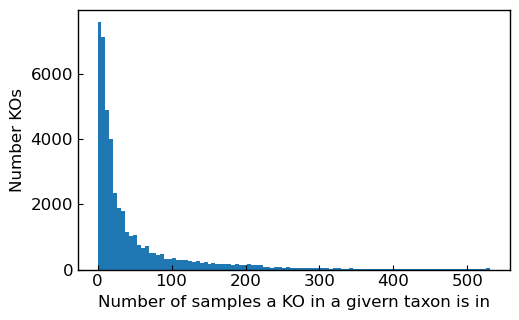

In [329]:
fig, ax = general_plot()
_ = ax.hist(list(dict_taxko_nsams.values()), bins=100)
_ = ax.set_xlabel('Number of samples a KO in a givern taxon is in')
_ = ax.set_ylabel('Number KOs')

## Compare bacteria and eukaryotes

Get dict defining each taxon as bacteria or eukaryote

In [331]:
dict_taxtrim_bacteuk = {}
for tax in taxa_all:
    lineage = ncbi.get_lineage(tax)
    if 2759 in lineage:
        dict_taxtrim_bacteuk[tax] = 'Eukaryota'
    elif 2 in lineage:
        dict_taxtrim_bacteuk[tax] = 'Bacteria'
    else:
        dict_taxtrim_bacteuk[tax] = 'other'

How many bacterial vs eukaryota KOs?

In [335]:
dict_ko_ebsset = defaultdict(set)
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
    for ko, _ in dkse.items():
        eb = dict_taxtrim_bacteuk[tax]
        dict_ko_ebsset[ko].add(eb)

dict_ko_ebs = {}
for ko, ebs in dict_ko_ebsset.items():
    if ebs:
        dict_ko_ebs[ko] = ', '.join(str(x) for x in ebs)
    else:
        dict_ko_ebs[ko] = 'none'
    

/tmp/ipykernel_1947816/2977368977.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(names,rotation=45, ha='right')


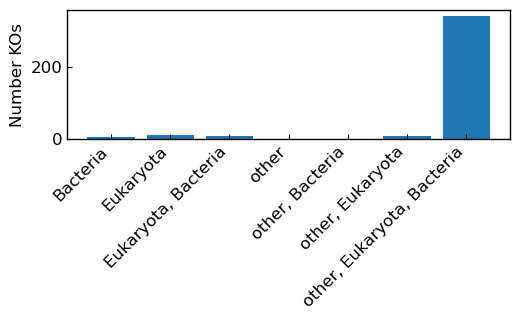

In [336]:
names, counts = np.unique(list(dict_ko_ebs.values()), return_counts=True)

fig, ax = general_plot()
_ = ax.bar(names, counts)
_ = ax.set_ylabel('Number KOs')
_ = ax.set_xticklabels(names,rotation=45, ha='right')


Which KOs are only in bacteria?

In [339]:
for ko, ebs, in dict_ko_ebs.items():
    if (ebs == 'Bacteria'):
        print(dict_ko_name[ko])

K19792  FET4; low-affinity ferrous iron transport protein
K24112  asbE; petrobactin synthase [EC:2.-.-.-]
K02568  napB; nitrate reductase (cytochrome), electron transfer subunit
K02570  napD; periplasmic nitrate reductase NapD
K02571  napE; periplasmic nitrate reductase NapE
K13255  fhuF; ferric iron reductase protein FhuF
K04041  fbp3; fructose-1,6-bisphosphatase III [EC:3.1.3.11]


Which KOs are only in eukaryota?

In [340]:
for ko, ebs, in dict_ko_ebs.items():
    if (ebs == 'Eukaryota'):
        print(dict_ko_name[ko])

K14685  SLC40A1, FPN1; solute carrier family 40 (iron-regulated transporter), member 1
K02721  psbW; photosystem II PsbW protein
K13625  FTL; ferritin light chain
K03541  psbR; photosystem II 10kDa protein
K02695  psaH; photosystem I subunit VI
K02701  psaN; photosystem I subunit PsaN
K26138  nasE; nitrite reductase [NAD(P)H] small subunit [EC:1.7.1.4]
K08197  ARN; MFS transporter, SIT family, siderophore-iron:H+ symporter
K10123  feoC; putative ferrous iron transport protein C
K04250  RHO, OPN2; rhodopsin
K22962  NP7; nitrite dismutase [EC:1.7.6.1]


## Make a tensor with only a few taxa

Get tensor filename

In [415]:
fn_tensor = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-barnacle_tensor_tidy.csv'
os.path.exists(fn_tensor)

True

Get header

In [416]:
with open(fn_tensor, 'r') as f:
    print(next(f))
    print(next(f))


assm_sample,KO,taxon_trim,estcounts,rep

G1NS-S13C1-3um,K15577,69277,0.0,A



Output filename

In [417]:
fn_tensor_sub = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-barnacle_tensor_tidy-subset_taxa_01.csv"

Get a list of taxa to subset

In [418]:
# Species, taxid, nkos
nodes_sub_01 = [
    "Pelagomonas calceolata,35677,252",
    "Pelagococcus subviridis,35679,106",
    "Aureococcus anophagefferens,44056,181",
]

nodes_sub_02 = [
    "Stramenopiles sp. TOSAG23-1,1735742,46",
    "Stramenopiles sp. TOSAG23-2,1735743,101",
    "Stramenopiles sp. TOSAG41-1,1735744,46",
    "Stramenopiles sp. TOSAG23-3,1735745,64",
    "Pelagomonas calceolata,35677,252",
    "Pelagococcus subviridis,35679,106",
    "Aureococcus anophagefferens,44056,181",
    "Thalassiosira minuscula,385413,73",
    "Thalassiosira bioculata,1048533,65",
    "Thalassiosira oceanica CCMP1005,637379,45",
    "Alteromonas australica,589873,90",
    "Alteromonas mediterranea,314275,47",
    "Alteromonas macleodii,28108,91",
    "Pseudoalteromonas lipolytica SCSIO 04301,1452721,178",
    "Pseudoalteromonas sp. '520P1 No. 412',304208,51",
    "Sulfitobacter indolifex HEL-45,391624,47",
    "Acinetobacter venetianus,52133,79",
]

taxa_sub = []
for t in nodes_sub_01:
    _, tid, _ = t.split(',')
    taxa_sub.append(tid)

taxa_sub = set(taxa_sub)
taxa_sub

{'35677', '35679', '44056'}

Write rows to tidytable

In [420]:
i = 0
with open(fn_tensor, 'r') as fr, open(fn_tensor_sub, 'w') as fw:
    row = next(fr)
    fw.write(row)
    for row in fr:
        sample, ko, tax, estcounts, rep = row.split(",")
        if tax in taxa_sub:
            i += 1
            fw.write(row)

i

101460

## Make a G3NS tensor with only a few taxa

Get tensor filename

In [352]:
fn_tensor = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/G3NS_kofam2021_ALL.csv-iron_KOs.txt-tidys/G3NS_kofam2021_ALL.csv-iron_KOs.txt-barnacle_tensor_tidy.csv"
os.path.exists(fn_tensor)

True

Get header

In [354]:
with open(fn_tensor, 'r') as f:
    print(next(f))
    print(next(f))


assm_sample,KO,taxon_trim,estcounts,rep

G3.UW.NS-UW38-nan-nan-1.7m-3um,K00216,356,0.0,B



Read in dict

In [355]:
dict_taxtrim_ko_sample_estcounts = defaultdict(
    lambda: defaultdict(dict)
)
i = 0
with open(fn_tensor, 'r') as f:
    _ = next(f)
    for row in f:
        i += 1
        sample, ko, tax, estcounts, rep = row.split(',')
        sam = f"{sample}-{rep}"
        dict_taxtrim_ko_sample_estcounts[tax][ko][sam] = float(estcounts)
i

643155

How many KOs, contigs, taxa, samples are there?

In [356]:
taxa_all = set()
kos_all = set()
samples_all = set()
taxko_all = set()
for tax, dkse in dict_taxtrim_ko_sample_estcounts.items():
  taxa_all.add(tax)
  for ko, dse in dkse.items():
    taxko_all.add(f"{tax}-{ko}")
    kos_all.add(ko)
    for sam, ec in dse.items():
      samples_all.add(sam)

In [357]:
print(f"""
There are 
    {len(kos_all)} KOs 
    {len(taxa_all)} taxa
    {len(samples_all)} samples
    {len(taxko_all)} taxon-kos
      """)


There are 
    360 KOs 
    166 taxa
    53 samples
    12135 taxon-kos
      


Build tree

In [358]:
tree = ncbi.get_topology(taxa_all)
for n in tree.traverse():
    if str(n.name) in taxa_all:
        kos = list(dict_taxtrim_ko_sample_estcounts[n.name].keys())
        nkos = len(kos)
    else:
        nkos = 'NA'
    n.add_props(
        nkos=nkos
    )


Plot tree

In [359]:
print(tree.to_str(props=['sci_name','name','nkos'], compact=True))

                                                                                                                                                                                                                                                                               ╭╴unclassified Diplodasys,2642610,92╶┬╴Diplodasys sp. 214385728,2183216,33
                                                                                                                                                                                                                                               ╭╴Thaumastodermatidae,233137,60╶┤                                    ╰╴Diplodasys sp. 184616435,2183232,36
                                                                                                                                                                                                                                               │                               │                                    

### 7 taxa

Output filename

In [362]:
fn_tensor_sub = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/G3NS_kofam2021_ALL.csv-iron_KOs.txt-tidys/G3NS_kofam2021_ALL.csv-iron_KOs.txt-barnacle_tensor_tidy-sub_taxa_01.csv"

Get a list of taxa to subset

In [363]:
# Species, taxid, nkos
nodes_sub_01 = [
    "Pseudoalteromonas sp. '520P1 No. 412',304208,47",
    "Alteromonas,226,86",
    "Roseobacteraceae,2854170,45",
    "Paracoccaceae,31989,52",
    "Pelagomonas calceolata,35677,134",
    "Thalassiosira,35127,42",
    "Stramenopiles MAST-4,1735725,60",
]


taxa_sub = []
for t in nodes_sub_01:
    _, tid, _ = t.split(',')
    taxa_sub.append(tid)

taxa_sub = set(taxa_sub)
taxa_sub

{'1735725', '226', '2854170', '304208', '31989', '35127', '35677'}

Write rows to tidytable

In [366]:
i = 0
with open(fn_tensor, 'r') as fr, open(fn_tensor_sub, 'w') as fw:
    row = next(fr)
    fw.write(row)
    for row in fr:
        sample, ko, tax, estcounts, rep = row.split(",")
        if tax in taxa_sub:
            i += 1
            fw.write(row)

i

24698

### 14 taxa

Output filename

In [378]:
fn_tensor_sub = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/G3NS_kofam2021_ALL.csv-iron_KOs.txt-tidys/G3NS_kofam2021_ALL.csv-iron_KOs.txt-barnacle_tensor_tidy-sub_taxa_02.csv"

Get a list of taxa to subset

In [379]:
# Species, taxid, nkos
nodes_sub_01 = [
    "Pseudoalteromonas sp. '520P1 No. 412',304208,47",
    "Alteromonas,226,86",
    "Roseobacteraceae,2854170,45",
    "Paracoccaceae,31989,52",
    "Pelagomonas calceolata,35677,134",
    "Thalassiosira,35127,42",
    "Stramenopiles MAST-4,1735725,60",
    "Flavobacteriaceae,49546,139",
    "Flavobacteria bacterium MS024-2A,487796,61",
    "Alphaproteobacteria,28211,143",
    "Vibrionales,135623,158",
    "Dinophyceae,2864,225",
    "Chlorophyta,3041,80",
    "Ochrophyta,2696291,167"


]


taxa_sub = []
for t in nodes_sub_01:
    _, tid, _ = t.split(',')
    taxa_sub.append(tid)

taxa_sub = set(taxa_sub)
taxa_sub

{'135623',
 '1735725',
 '226',
 '2696291',
 '28211',
 '2854170',
 '2864',
 '3041',
 '304208',
 '31989',
 '35127',
 '35677',
 '487796',
 '49546'}

Write rows to tidytable

In [380]:
i = 0
with open(fn_tensor, 'r') as fr, open(fn_tensor_sub, 'w') as fw:
    row = next(fr)
    fw.write(row)
    for row in fr:
        sample, ko, tax, estcounts, rep = row.split(",")
        if tax in taxa_sub:
            i += 1
            fw.write(row)

i

76267

In [342]:
taxa = [      2,     976,    2759,   49546, 2696291,  131567,    2864,
         35677,    1236,   33313,   78238,    3041,    2916,    2836,
        200644, 2698737,   35675,   33656,  135623,   28211]

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[t])

2 Bacteria
976 Bacteroidota
2759 Eukaryota
49546 Flavobacteriaceae
2696291 Ochrophyta
131567 cellular organisms
2864 Dinophyceae
35677 Pelagomonas calceolata
1236 Gammaproteobacteria
33313 Gastrotricha
78238 Macrodasyida
3041 Chlorophyta
2916 Tripos fusus
2836 Bacillariophyta
200644 Flavobacteriales
2698737 Sar
35675 Pelagophyceae
33656 Phaeocystis
135623 Vibrionales
28211 Alphaproteobacteria


Component 1

In [371]:
taxa = ['35677', '31989', '226', '304208']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

35677 Pelagomonas calceolata
31989 Paracoccaceae
226 Alteromonas
304208 Pseudoalteromonas sp. '520P1 No. 412'


In [368]:
kos = ['K02722', 'K00372' ,'K07214', 'K02691', 'K00855', 'K02709']

for k in kos:
    print(dict_ko_name[k])

K02722  psbX; photosystem II PsbX protein
K00372  nasC,  nasA; assimilatory nitrate reductase catalytic subunit [EC:1.7.99.-]
K07214  fes; iron(III)-enterobactin esterase [EC:3.1.1.108]
K02691  psaC; photosystem I iron-sulfur center [EC:1.97.1.12]
K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]
K02709  psbH; photosystem II PsbH protein


Component 2

In [377]:
taxa = ['35677', '226','35127']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

35677 Pelagomonas calceolata
226 Alteromonas
35127 Thalassiosira


In [369]:
kos = ['K00532', 'K06441', 'K22338', 'K02705', 'K22341', 'K10850', 'K00372', 'K02598', 'K01602', 'K02567', 'K02709']
for k in kos:
    print(dict_ko_name[k])

K00532  E1.12.7.2; ferredoxin hydrogenase [EC:1.12.7.2]
K06441  E1.12.7.2G; ferredoxin hydrogenase gamma subunit [EC:1.12.7.2]
K22338  hylA; formate dehydrogenase (NAD+, ferredoxin) subunit A [EC:1.17.1.11]
K02705  psbC; photosystem II CP43 chlorophyll apoprotein
K22341  fdhF2; formate dehydrogenase (NAD+, ferredoxin) subunit [EC:1.17.1.11]
K10850  narT; MFS transporter, NNP family, putative nitrate transporter
K00372  nasC,  nasA; assimilatory nitrate reductase catalytic subunit [EC:1.7.99.-]
K02598  nirC; nitrite transporter
K01602  rbcS, cbbS; ribulose-bisphosphate carboxylase small chain [EC:4.1.1.39]
K02567  napA; nitrate reductase (cytochrome) [EC:1.9.6.1]
K02709  psbH; photosystem II PsbH protein


Component 3

In [373]:

taxa = ['1735725', '31989', '226', '35127']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

1735725 Stramenopiles MAST-4
31989 Paracoccaceae
226 Alteromonas
35127 Thalassiosira


In [375]:
kos = ['K00368', 'K16087', 'K22552', 'K02567', 'K19611', 'K04565']
for k in kos:
    print(dict_ko_name[k])

K00368  nirK; nitrite reductase (NO-forming) [EC:1.7.2.1]
K16087  TC.FEV.OM3, tbpA, hemR, lbpA, hpuB, bhuR, hugA, hmbR; hemoglobin/transferrin/lactoferrin receptor protein
K22552  mmcO; multicopper oxidase [EC:1.16.3.1]
K02567  napA; nitrate reductase (cytochrome) [EC:1.9.6.1]
K19611  fepA, pfeA, iroN, pirA; ferric enterobactin receptor
K04565  SOD1; superoxide dismutase, Cu-Zn family [EC:1.15.1.1]


Component 4

In [374]:

taxa = ['35127', '226', '304208', '1735725']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

35127 Thalassiosira
226 Alteromonas
304208 Pseudoalteromonas sp. '520P1 No. 412'
1735725 Stramenopiles MAST-4


In [376]:
kos = ['K07214', 'K23723', 'K10850', 'K07243', 'K01595', 'K00855']
for k in kos:
    print(dict_ko_name[k])

K07214  fes; iron(III)-enterobactin esterase [EC:3.1.1.108]
K23723  iroD; iron(III)-salmochelin esterase [EC:3.1.1.109]
K10850  narT; MFS transporter, NNP family, putative nitrate transporter
K07243  FTR, FTH1, efeU; high-affinity iron transporter
K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]
K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]


## Subset 02

Component 23

In [390]:

taxa = ['135623', '28211', '49546', '2864']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

135623 Vibrionales
28211 Alphaproteobacteria
49546 Flavobacteriaceae
2864 Dinophyceae


In [389]:
kos = ['K03320', 'K00362']
for k in kos:
    print(dict_ko_name[k])

K03320  amt, AMT, MEP; ammonium transporter, Amt family
K00362  nirB; nitrite reductase (NADH) large subunit [EC:1.7.1.15]


In [400]:
samples = ['G3.UW.NS-UW32-32.93-3.7m-0.2um', 'G3.UW.NS-UW29-29.46-1.7m-0.2um', 'G3.UW.NS-UW25-25.87-1.7m-0.2um', 'G3.UW.NS-UW32-32.93-3.7m-3um', 'G3.UW.NS-UW31-31.43-2.7m-3um', 'G3.UW.NS-UW35-35.83-2.7m-0.2um', 'G3.UW.NS-UW32-32.3-1.7m-3um', 'G3.UW.NS-UW32-32.3-1.7m-0.2um', 'G3.UW.NS-UW37-37.0-1.7m-0.2um', 'G3.UW.NS-UW35-35.83-2.7m-3um']
lats = []
infos = []
for s in samples:
    assm, sam, lat, depth, size = s.split('-')
    lats.append(lat)
    infos.append(f"{lat}-{depth}-{size}")

# [x for _, x in sorted(zip(lats, infos))]
infos

['32.93-3.7m-0.2um',
 '29.46-1.7m-0.2um',
 '25.87-1.7m-0.2um',
 '32.93-3.7m-3um',
 '31.43-2.7m-3um',
 '35.83-2.7m-0.2um',
 '32.3-1.7m-3um',
 '32.3-1.7m-0.2um',
 '37.0-1.7m-0.2um',
 '35.83-2.7m-3um']

Component 58

In [396]:

taxa = ['487796', '226', '49546', '2696291', '3041']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

487796 Flavobacteria bacterium MS024-2A
226 Alteromonas
49546 Flavobacteriaceae
2696291 Ochrophyta
3041 Chlorophyta


In [397]:
kos = ['K19611', 'K06503', 'K00264', 'K01851', 'K00265', 'K16090', 'K25224', 'K00615', 'K00134', 'K03832']

for k in kos:
    print(dict_ko_name[k])

K19611  fepA, pfeA, iroN, pirA; ferric enterobactin receptor
K06503  TFRC, CD71; transferrin receptor
K00264  GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
K01851  pchA; salicylate biosynthesis isochorismate synthase [EC:5.4.4.2]
K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]
K16090  fiu; catecholate siderophore receptor
K25224  gapdh; glyceraldehyde-3-phosphate dehydrogenase (arsenate-transferring) [EC:1.2.1.107]
K00615  E2.2.1.1, tktA, tktB; transketolase [EC:2.2.1.1]
K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
K03832  tonB; periplasmic protein TonB


In [399]:
samples = ['G3.UW.NS-UW32-32.93-3.7m-0.2um', 'G3.UW.NS-UW32-32.3-1.7m-0.2um', 'G3.UW.NS-UW29-29.46-1.7m-0.2um', 'G3.UW.NS-UW25-25.87-1.7m-0.2um', 'G3.UW.NS-UW35-35.96-1.7m-0.2um', 'G3.UW.NS-UW32-32.3-1.7m-3um', 'G3.UW.NS-UW31-31.43-2.7m-3um', 'G3.UW.NS-UW40-40.09-2.7m-0.2um', 'G3.UW.NS-UW32-32.93-3.7m-3um', 'G3.UW.NS-UW25-25.87-1.7m-3um']

lats = []
infos = []
for s in samples:
    assm, sam, lat, depth, size = s.split('-')
    lats.append(lat)
    infos.append(f"{lat}-{depth}-{size}")

infos

['32.93-3.7m-0.2um',
 '32.3-1.7m-0.2um',
 '29.46-1.7m-0.2um',
 '25.87-1.7m-0.2um',
 '35.96-1.7m-0.2um',
 '32.3-1.7m-3um',
 '31.43-2.7m-3um',
 '40.09-2.7m-0.2um',
 '32.93-3.7m-3um',
 '25.87-1.7m-3um']

Component 62

In [401]:

taxa = ['2864', '2696291', '35677', '49546', '28211', '3041', '135623', '1735725', '35127', '226']

dict_tax_name = ncbi.get_taxid_translator(taxa)

for t in taxa:
    print(t,dict_tax_name[int(t)])

2864 Dinophyceae
2696291 Ochrophyta
35677 Pelagomonas calceolata
49546 Flavobacteriaceae
28211 Alphaproteobacteria
3041 Chlorophyta
135623 Vibrionales
1735725 Stramenopiles MAST-4
35127 Thalassiosira
226 Alteromonas


In [402]:
kos = ['K00264', 'K00265', 'K00284', 'K01673', 'K00266', 'K00615', 'K01624', 'K04759', 'K24034', 'K02364']

for k in kos:
    print(dict_ko_name[k])

K00264  GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]
K00284  GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
K01673  cynT, can; carbonic anhydrase [EC:4.2.1.1]
K00266  gltD; glutamate synthase (NADPH) small chain [EC:1.4.1.13]
K00615  E2.2.1.1, tktA, tktB; transketolase [EC:2.2.1.1]
K01624  FBA, fbaA; fructose-bisphosphate aldolase, class II [EC:4.1.2.13]
K04759  feoB; ferrous iron transport protein B
K24034  SPE3-LYS9; spermidine synthase / saccharopine dehydrogenase (NADP+, L-glutamate-forming) [EC:2.5.1.16 1.5.1.10]
K02364  entF; L-serine---[L-seryl-carrier protein] ligase [EC:6.3.2.14 6.2.1.72]


In [403]:
samples = ['G3.UW.NS-UW40-40.88-1.7m-3um', 'G3.UW.NS-UW40-40.88-1.7m-0.2um', 'G3.UW.NS-UW38-38.97-1.7m-3um', 'G3.UW.NS-UW29-29.46-1.7m-3um', 'G3.UW.NS-UW38-38.97-1.7m-0.2um', 'G3.UW.NS-UW35-35.96-1.7m-3um', 'G3.UW.NS-UW40-40.09-2.7m-3um', 'G3.UW.NS-UW35-35.96-1.7m-0.2um', 'G3.UW.NS-UW32-32.3-1.7m-3um', 'G3.UW.NS-UW25-25.87-1.7m-3um']

lats = []
infos = []
for s in samples:
    assm, sam, lat, depth, size = s.split('-')
    lats.append(lat)
    infos.append(f"{lat}-{depth}-{size}")

infos

['40.88-1.7m-3um',
 '40.88-1.7m-0.2um',
 '38.97-1.7m-3um',
 '29.46-1.7m-3um',
 '38.97-1.7m-0.2um',
 '35.96-1.7m-3um',
 '40.09-2.7m-3um',
 '35.96-1.7m-0.2um',
 '32.3-1.7m-3um',
 '25.87-1.7m-3um']

Taxa clusters

In [410]:
taxa = ['226', '2864', '3041', '28211', '31989', '35127', '35677', '49546',
       '135623', '304208', '487796', '1735725', '2696291', '2854170']

dict_tax_name = ncbi.get_taxid_translator(taxa)
dtn = {}
for t in taxa:
    print(t,dict_tax_name[int(t)])
    dtn[t] = dict_tax_name[int(t)]
dtn

226 Alteromonas
2864 Dinophyceae
3041 Chlorophyta
28211 Alphaproteobacteria
31989 Paracoccaceae
35127 Thalassiosira
35677 Pelagomonas calceolata
49546 Flavobacteriaceae
135623 Vibrionales
304208 Pseudoalteromonas sp. '520P1 No. 412'
487796 Flavobacteria bacterium MS024-2A
1735725 Stramenopiles MAST-4
2696291 Ochrophyta
2854170 Roseobacteraceae


{'226': 'Alteromonas',
 '2864': 'Dinophyceae',
 '3041': 'Chlorophyta',
 '28211': 'Alphaproteobacteria',
 '31989': 'Paracoccaceae',
 '35127': 'Thalassiosira',
 '35677': 'Pelagomonas calceolata',
 '49546': 'Flavobacteriaceae',
 '135623': 'Vibrionales',
 '304208': "Pseudoalteromonas sp. '520P1 No. 412'",
 '487796': 'Flavobacteria bacterium MS024-2A',
 '1735725': 'Stramenopiles MAST-4',
 '2696291': 'Ochrophyta',
 '2854170': 'Roseobacteraceae'}

KO clusters 2

In [405]:
kos = ['K07214', 'K10850', 'K04783', 'K00372', 'K23723', 'K16087', 'K04564',
       'K00855', 'K02217', 'K02705']

for k in kos:
    print(dict_ko_name[k])

K07214  fes; iron(III)-enterobactin esterase [EC:3.1.1.108]
K10850  narT; MFS transporter, NNP family, putative nitrate transporter
K04783  irp5, ybtE; yersiniabactin salicyl-AMP ligase [EC:6.3.2.-]
K00372  nasC,  nasA; assimilatory nitrate reductase catalytic subunit [EC:1.7.99.-]
K23723  iroD; iron(III)-salmochelin esterase [EC:3.1.1.109]
K16087  TC.FEV.OM3, tbpA, hemR, lbpA, hpuB, bhuR, hugA, hmbR; hemoglobin/transferrin/lactoferrin receptor protein
K04564  SOD2; superoxide dismutase, Fe-Mn family [EC:1.15.1.1]
K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]
K02217  ftnA, ftn; ferritin [EC:1.16.3.2]
K02705  psbC; photosystem II CP43 chlorophyll apoprotein


KO clusters 3

In [406]:
kos = ['K19611', 'K06503', 'K00265', 'K16090', 'K01851', 'K08906', 'K11707',
       'K11709', 'K11710', 'K11951']

for k in kos:
    print(dict_ko_name[k])

K19611  fepA, pfeA, iroN, pirA; ferric enterobactin receptor
K06503  TFRC, CD71; transferrin receptor
K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]
K16090  fiu; catecholate siderophore receptor
K01851  pchA; salicylate biosynthesis isochorismate synthase [EC:5.4.4.2]
K08906  petJ; cytochrome c6
K11707  troA, mntA, znuA; manganese/zinc/iron transport system substrate-binding protein
K11709  troD, mntD, znuB; manganese/zinc/iron transport system permease protein
K11710  troB, mntB, znuC; manganese/zinc/iron transport system ATP- binding protein [EC:7.2.2.5]
K11951  cmpB; bicarbonate transport system permease protein


KO clusters 8

In [407]:
kos = ['K01595', 'K00134', 'K01803', 'K01624', 'K16088', 'K00927', 'K00615',
       'K04565', 'K04782', 'K11951']

for k in kos:
    print(dict_ko_name[k])

K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]
K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
K01803  TPI, tpiA; triosephosphate isomerase (TIM) [EC:5.3.1.1]
K01624  FBA, fbaA; fructose-bisphosphate aldolase, class II [EC:4.1.2.13]
K16088  TC.FEV.OM1, fhuE, fpvA, fptA; outer-membrane receptor for ferric coprogen and ferric-rhodotorulic acid
K00927  PGK, pgk; phosphoglycerate kinase [EC:2.7.2.3]
K00615  E2.2.1.1, tktA, tktB; transketolase [EC:2.2.1.1]
K04565  SOD1; superoxide dismutase, Cu-Zn family [EC:1.15.1.1]
K04782  pchB; isochorismate pyruvate lyase [EC:4.2.99.21]
K11951  cmpB; bicarbonate transport system permease protein


KO clusters 9

In [408]:
kos = ['K00264', 'K01595', 'K16087', 'K02638', 'K03699', 'K00175', 'K00265',
       'K00179', 'K01601', 'K07684']

for k in kos:
    print(dict_ko_name[k])

K00264  GLT1; glutamate synthase (NADH) [EC:1.4.1.14]
K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]
K16087  TC.FEV.OM3, tbpA, hemR, lbpA, hpuB, bhuR, hugA, hmbR; hemoglobin/transferrin/lactoferrin receptor protein
K02638  petE; plastocyanin
K03699  tlyC; magnesium and cobalt exporter, CNNM family
K00175  korB, oorB, oforB; 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit beta [EC:1.2.7.3 1.2.7.11]
K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]
K00179  iorA; indolepyruvate ferredoxin oxidoreductase, alpha subunit [EC:1.2.7.8]
K01601  rbcL, cbbL; ribulose-bisphosphate carboxylase large chain [EC:4.1.1.39]
K07684  narL; two-component system, NarL family, nitrate/nitrite response regulator NarL


Sample cluster 7 and 17 and 2 and 4

In [414]:
kos = ['K00265', 'K00368', 'K00615', 'K00855', 'K01012', 'K01601', 'K01602',
       'K01624', 'K01672', 'K01673', 'K02364', 'K02639', 'K02689', 'K02695',
       'K02699', 'K02703', 'K02704', 'K02705', 'K02706', 'K02708', 'K02711',
       'K02717', 'K02718', 'K02721', 'K02722', 'K02724', 'K03320', 'K03542',
       'K03594', 'K03839', 'K03841', 'K04564', 'K04565', 'K04755', 'K04759',
       'K04784', 'K04787', 'K05374', 'K05524', 'K07214', 'K08940', 'K10850',
       'K11645', 'K12237', 'K13859', 'K13860', 'K16087', 'K21567', 'K22336',
       'K22552', 'K23723', 'K24110',
       
       'K00264', 'K00265', 'K00266', 'K00284', 'K00362', 'K00522', 'K00532',
       'K00855', 'K01601', 'K01602', 'K02011', 'K02574', 'K02697', 'K02699',
       'K02706', 'K02714', 'K02716', 'K02722', 'K03320', 'K03594', 'K03841',
       'K04565', 'K04641', 'K04784', 'K04786', 'K06441', 'K06503', 'K08906',
       'K11959', 'K13575', 'K14578', 'K15579', 'K16087', 'K19611', 'K19791',
       'K21949', 'K22336', 'K22338', 'K22339', 'K23184', 'K23910', 'K25286',

       'K02012', 'K02689', 'K02690', 'K02711', 'K02717', 'K02724',

       'K00265', 'K00372', 'K01595', 'K02704', 'K02716', 'K02719', 'K02720',
       'K03839', 'K04564', 'K04783', 'K05710', 'K07214', 'K14718', 'K23725',
       'K24245'
]
dkn = {}
for k in kos:
    dkn[k] = dict_ko_name[k]
dkn

{'K00265': 'K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]',
 'K00368': 'K00368  nirK; nitrite reductase (NO-forming) [EC:1.7.2.1]',
 'K00615': 'K00615  E2.2.1.1, tktA, tktB; transketolase [EC:2.2.1.1]',
 'K00855': 'K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]',
 'K01012': 'K01012  bioB; biotin synthase [EC:2.8.1.6]',
 'K01601': 'K01601  rbcL, cbbL; ribulose-bisphosphate carboxylase large chain [EC:4.1.1.39]',
 'K01602': 'K01602  rbcS, cbbS; ribulose-bisphosphate carboxylase small chain [EC:4.1.1.39]',
 'K01624': 'K01624  FBA, fbaA; fructose-bisphosphate aldolase, class II [EC:4.1.2.13]',
 'K01672': 'K01672  CA; carbonic anhydrase [EC:4.2.1.1]',
 'K01673': 'K01673  cynT, can; carbonic anhydrase [EC:4.2.1.1]',
 'K02364': 'K02364  entF; L-serine---[L-seryl-carrier protein] ligase [EC:6.3.2.14 6.2.1.72]',
 'K02639': 'K02639  petF; ferredoxin',
 'K02689': 'K02689  psaA; photosystem I P700 chlorophyll a apoprotein A1 [EC:1.97.1.12]',
 'K02695': 'K02695  psaH; pho

taxon cluster 1 and 4

In [413]:
kos = [
    'K00265', 'K01012', 'K01595', 'K01672', 'K01726', 'K02217', 'K02255',
    'K02364', 'K02638', 'K02639', 'K03320', 'K04564', 'K04641', 'K04783',
    'K04784', 'K05524', 'K07214', 'K12237', 'K16087', 'K19611', 'K22336',
    'K22552', 'K23910', 'K25224',

    'K03320'
]
dkn = {}
for k in kos:
    dkn[k] = dict_ko_name[k]
dkn

{'K00265': 'K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]',
 'K01012': 'K01012  bioB; biotin synthase [EC:2.8.1.6]',
 'K01595': 'K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]',
 'K01672': 'K01672  CA; carbonic anhydrase [EC:4.2.1.1]',
 'K01726': 'K01726  GAMMACA; gamma-carbonic anhydrase [EC:4.2.1.-]',
 'K02217': 'K02217  ftnA, ftn; ferritin [EC:1.16.3.2]',
 'K02255': 'K02255  ftnB; ferritin-like protein 2',
 'K02364': 'K02364  entF; L-serine---[L-seryl-carrier protein] ligase [EC:6.3.2.14 6.2.1.72]',
 'K02638': 'K02638  petE; plastocyanin',
 'K02639': 'K02639  petF; ferredoxin',
 'K03320': 'K03320  amt, AMT, MEP; ammonium transporter, Amt family',
 'K04564': 'K04564  SOD2; superoxide dismutase, Fe-Mn family [EC:1.15.1.1]',
 'K04641': 'K04641  bop; bacteriorhodopsin',
 'K04783': 'K04783  irp5, ybtE; yersiniabactin salicyl-AMP ligase [EC:6.3.2.-]',
 'K04784': 'K04784  irp2, HMWP2; yersiniabactin nonribosomal peptide synthetase',
 'K05524': 'K05524  fdxA

Sample

## Test batch minimum tree trimming

In [422]:
sys.path.append('../repo-armbrust-metat-search/functions')
from cl_tree_trim_02 import TreeTrim

### Write a test table with only two batches

get tensor filename

In [435]:
fn_tidy_merge = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_all.csv'
with open(fn_tidy_merge, 'r') as f:
    print(next(f))
    print(next(f))

contig,fn_sample_counts,KO,taxon,estcounts

D1PA_S06C1_TRINITY_DN1222081_c0_g1_i1_1,D1PA.S06C1_C_600.abundance.tsv,K00134,131567,0



Get metadata

In [428]:
fn_meta = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-metadata.csv'
metadata = pd.read_csv(fn_meta)
metadata[:2]

,assembly,sample,latitude,ammendment,timepoint,depth,size,rep,fn_sample_counts,assm_sample
0,D1PA,S06C1,NaN,NaN,600,NaN,NaN,C,D1PA.S06C1_C_600.abundance.tsv,D1PA-S06C1-600
1,D1PA,S15C1,NaN,NaN,200,NaN,NaN,C,D1PA.S15C1_C_200.abundance.tsv,D1PA-S15C1-200


Output filename

In [436]:
merges = ['D1PA','G1PA']
fn_tidy_merge_sub = f"/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_merge_{merges[0]}_{merges[1]}.csv"
out_dir = os.path.split(fn_tidy_merge_sub)[0]
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f"Made dir: {out_dir}")

Write new file

In [438]:
# Get dict sample batch
dict_sample_batch = dict(zip(
    metadata['fn_sample_counts'],
    metadata['assembly']
))
merges = set(merges)  # faster "in"
# count rows written
i = 0
# open read and write
with open(fn_tidy_merge, 'r') as fr, open(fn_tidy_merge_sub, 'w') as fw:
    row = next(fr)
    fw.write(row)
    for row in fr:
        contig, sample, ko, tax, estcounts = row.split(",")
        batch = dict_sample_batch[sample]
        if batch in merges:
            i += 1
            fw.write(row)

i

25072029

### Trim tree with subset merge 

Load object

In [440]:
tree = TreeTrim(fn_tidy_merge_sub)

Loading dicts for /scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_merge_D1PA_G1PA.csv...
Current memory usage: 3077.00 MB
Time to load dicts from /scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_merge_D1PA_G1PA.csv: 1.0 min 40.10804009437561 sec
Current memory usage: 6290.95 MB


/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1547445 was translated into 653937
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1301032 was translated into 1432050
  warnings.warn('taxid %s was translated into %s' %


Trim

In [442]:
tree.trim_tree(
    'nkos_in_gt_minbatches',
    thresh=30,
    dict_sample_batch=dict_sample_batch,
    minsamples=3,
    minbatches=2
)

Inspect tree

In [443]:
print(tree.treetrim.to_str(props=['sci_name','name'], compact=True))

                           ╭╴Bacteria,2╶╌╴Pseudomonadati,3379134
                           │                                                                        ╭╴Protostomia,33317╶╌╴Neocopepoda,116569╶┬╴Podoplea,116571
                           │                ╭╴Opisthokonta,33154╶╌╴Eumetazoa,6072╶╌╴Bilateria,33213╶┤                                        ╰╴Calanoida,6833╶╌╴Calanidae,6835
                           │                │                                                       ╰╴Oikopleura dioica,34765
                           │                │                                                                       ╭╴Kareniaceae,1003176╶┬╴Karlodinium veneficum,407301
╴cellular organisms,131567╶┤                │                                                  ╭╴Gymnodiniales,2953╶┤                     ╰╴Karenia brevis,156230
                           │                │                                                  │                    ╰╴Gymnodinium catenatum GC74

Add info to trees

In [446]:
for n in tree.treetrim.traverse():
    tid = n.name
    nkos = 0
    for ko, d in tree.dict_taxtrim_ko_sam_estcounts[tid].items():
        dbs = defaultdict(int)
        for sam, estcounts in d.items():
            batch = dict_sample_batch[sam]
            dbs[batch] += bool(estcounts)
        minb = True
        for nsam in dbs.values():
            if nsam < 3:
                minb = False
        if minb:
            nkos += 1
    n.add_props(
        nkos=nkos
    )
print(tree.treetrim.to_str(props=['sci_name','name','nkos'], compact=True))

                               ╭╴Bacteria,2,95╶╌╴Pseudomonadati,3379134,76
                               │                                                                                     ╭╴Protostomia,33317,75╶╌╴Neocopepoda,116569,50╶┬╴Podoplea,116571,57
                               │                    ╭╴Opisthokonta,33154,61╶╌╴Eumetazoa,6072,56╶╌╴Bilateria,33213,57╶┤                                              ╰╴Calanoida,6833,60╶╌╴Calanidae,6835,60
                               │                    │                                                                ╰╴Oikopleura dioica,34765,41
                               │                    │                                                                                     ╭╴Kareniaceae,1003176,69╶┬╴Karlodinium veneficum,407301,107
╴cellular organisms,131567,131╶┤                    │                                                             ╭╴Gymnodiniales,2953,51╶┤                        ╰╴Karenia brevis,156230,93
  